# Taxi Data Challenge

## Overview

This notebook analyzes the NYC taxi trips data.

### Analysis questions:
1.	How would you assess the efficiency of aggregating rides within Astoria? From Astoria to Manhattan? From Manhattan to Astoria?
2.	How does this compare to our current area of service (e.g. the Upper East Side)?
3.	Would you provide rides only within Astoria for this new service or also between Astoria and Manhattan? Why? For reference, Via started as a commuter service between the Upper East Side and Midtown.
4.	Would you launch Astoria service during all our hours of operation (24/7) or only for certain hours? If so - which hours?

### Statistical questions 

*answer these theoretically, no need to implement:*

5.	If you were given a metric for efficiency (assume you don't know how it's calculated), how would you determine whether a specific zone is more efficient than the rest of the city? How would you determine why it’s more efficient?
6.	 How would you compare the distributions of intra-city trip prices between two different cities? How would you test whether any differences you find are explained by distance and duration?

### Analysis assumptions

1. seasonality is not considered in this analysis
2. trip distance is used as the distance between 2 locations. Although some trips may take deviation, we assume that is not likely for simplicity.
3. efficiency is measured in 3 measures: passenger per trip, time vs distance

## Environment Setup

In [54]:
import pandas as pd
import numpy as np
import datetime
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import shapefile as shp
import glob
import os

## Data Extraction and Transformation

In [55]:
# load data into dataframe
# the data is 2016_06 yellow cab and green cab data
df_yellow = pd.read_csv('trip_data/yellow_tripdata_2016-06.csv', header = 0)
df_green = pd.read_csv('trip_data/green_tripdata_2016-06.csv', header = 0)

In [56]:
# count of total records
df_yellow.shape

(11135470, 19)

In [57]:
# print schema
df_yellow.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [58]:
# convert pick up and drop off datetime from string to datetime variable type
df_yellow['pickup_datetime'] = pd.to_datetime(df_yellow['tpep_pickup_datetime'],format = '%Y-%m-%d %H:%M:%S')
df_yellow['dropoff_datetime'] = pd.to_datetime(df_yellow['tpep_dropoff_datetime'],format = '%Y-%m-%d %H:%M:%S')
# create a duration column in minutes
df_yellow['timeDifference'] = df_yellow['dropoff_datetime'] - df_yellow['pickup_datetime']
df_yellow['duration'] = df_yellow['timeDifference'].dt.seconds/60
# drop irrelevant columns
cols_to_drop = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag', 'payment_type',
               'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge']
df_yellow.drop(cols_to_drop, axis = 1, inplace = True)
df_yellow.rename(str.lower, axis='columns', inplace=True)

In [59]:
# print schema
df_yellow.dtypes

passenger_count                int64
trip_distance                float64
pickup_longitude             float64
pickup_latitude              float64
ratecodeid                     int64
dropoff_longitude            float64
dropoff_latitude             float64
tip_amount                   float64
total_amount                 float64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
timedifference       timedelta64[ns]
duration                     float64
dtype: object

In [60]:
# count of total records
df_green.shape

(1404726, 21)

In [61]:
# print schema
df_green.dtypes

VendorID                   int64
lpep_pickup_datetime      object
Lpep_dropoff_datetime     object
Store_and_fwd_flag        object
RateCodeID                 int64
Pickup_longitude         float64
Pickup_latitude          float64
Dropoff_longitude        float64
Dropoff_latitude         float64
Passenger_count            int64
Trip_distance            float64
Fare_amount              float64
Extra                    float64
MTA_tax                  float64
Tip_amount               float64
Tolls_amount             float64
Ehail_fee                float64
improvement_surcharge    float64
Total_amount             float64
Payment_type               int64
Trip_type                float64
dtype: object

In [62]:
# convert pick up and drop off datetime from string to datetime variable type
df_green['pickup_datetime'] = pd.to_datetime(df_green['lpep_pickup_datetime'],format = '%Y-%m-%d %H:%M:%S')
df_green['dropoff_datetime'] = pd.to_datetime(df_green['Lpep_dropoff_datetime'],format = '%Y-%m-%d %H:%M:%S')
# create a duration column in minutes
df_green['timeDifference'] = df_green['dropoff_datetime'] - df_green['pickup_datetime']
df_green['duration'] = df_green['timeDifference'].dt.seconds/60
# drop irrelevant columns
cols_to_drop = ['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 'Payment_type',
               'Fare_amount', 'Extra', 'MTA_tax', 'Ehail_fee', 'Tolls_amount', 'Trip_type ', 'improvement_surcharge']
df_green.drop(cols_to_drop, axis = 1, inplace = True)
df_green.rename(str.lower, axis='columns', inplace=True)

In [63]:
# print schema
df_green.dtypes

ratecodeid                     int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
trip_distance                float64
tip_amount                   float64
total_amount                 float64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
timedifference       timedelta64[ns]
duration                     float64
dtype: object

In [64]:
# concat yellow and green dataframe together
df = pd.concat([df_yellow, df_green], axis = 0, ignore_index=True)
df.dropna(inplace = True)

## Preliminary Data Exploration and Cleaning

In [65]:
# counts for each passenger count value
df['passenger_count'].value_counts()

1    9085157
2    1714645
5     625459
3     498597
6     381240
4     234169
0        754
7         88
8         62
9         25
Name: passenger_count, dtype: int64

- From the table above, one can infer that the regular passenger should be 1 to 6.
- This is matching the vehicle size assumption.
- Thus other values for passenger count (0, 7, 8, 9) will be dropped.

In [66]:
# drop records where passenger count is 0, or passenger count is > 6
df.drop(df[(df.passenger_count == 0) | (df.passenger_count > 6)].index, inplace = True)

In [67]:
# statistics for distance column
df.trip_distance.describe()

count    1.253927e+07
mean     3.025663e+00
std      2.059633e+01
min      0.000000e+00
25%      1.000000e+00
50%      1.740000e+00
75%      3.300000e+00
max      7.173270e+04
Name: trip_distance, dtype: float64

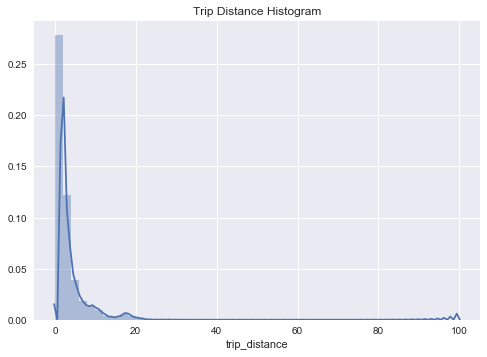

In [68]:
# histogram of trip distance for trip under 100 miles
# 100 mile is selected as a heuristic bound
plt.figure()
plt.title('Trip Distance Histogram')
sns.distplot(df[df['trip_distance']<100]['trip_distance'])
plt.show()

From the graph, it is evident that most trips are under 20 miles. We can take 30 as the upper bound as a conservative number and drop other records.

In [69]:
# drop records where trip distance is greater than 30 or trip distance is 0
df.drop(df[(df['trip_distance']>30) | (df['trip_distance'] == 0)].index, inplace = True)

In [70]:
# count relevant records
df.shape

(12445270, 13)

In [71]:
# duration statistics
df['duration'].describe()

count    1.244527e+07
mean     1.767089e+01
std      6.403940e+01
min      0.000000e+00
25%      6.866667e+00
50%      1.151667e+01
75%      1.891667e+01
max      1.439983e+03
Name: duration, dtype: float64

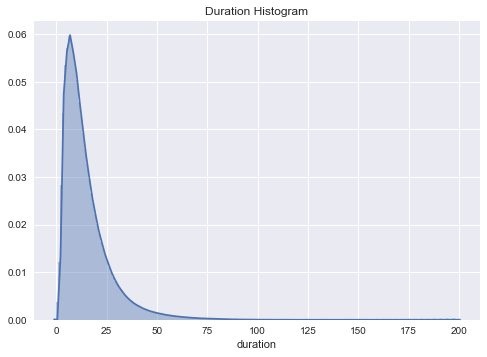

In [72]:
# histogram of duration for trip under 200 minutes
# 200 minutes is selected as a heuristic bound
plt.figure()
plt.title('Duration Histogram')
sns.distplot(df[df['duration']<200]['duration'], bins = 200)
plt.show()

From the graph, it is easy to see that the majority of the trip's duration is under 75 minutes. We can choose 100 as the conservative upper bound and drop records with duration above 100 minutes.

In [73]:
# drop records where duration is greater than 100 or duration is 0
df.drop(df[(df['duration']>100) | (df['duration'] == 0)].index, inplace = True)

In [74]:
# count relevant records
df.shape

(12410990, 13)

## Efficiency Calculation

### Passenger per trip efficiency

- We assume standard vehicle size suits 4 to 6 passengers. 

- Since there is no way of knowing the actual size of a vehicle from data, for each trip, we assume 4 to 6 as full load (100%).

- For each passenger cound under 4, we calculate the loading efficiency by dividing 4.

In [22]:
# create a new column as capacity
# if the passenger count >= 4, the capacity = 100%
# otherwise, capacity = passenger count / 4
df['capacity'] = df['passenger_count'].apply(lambda x: 1 if x >=4 else x/4)

In [23]:
# counts for each capacity value
df['capacity'].value_counts()

0.25    8985317
0.50    1698912
1.00    1232087
0.75     494674
Name: capacity, dtype: int64

In [24]:
df['capacity'].size

12410990

### Speed Efficiency

- Speed is calculated as miles/minute

In [25]:
# create a column as speed
df['speed'] = df['trip_distance']/df['duration']

In [26]:
df['speed'].describe()

count    1.241099e+07
mean     2.294585e-01
std      2.679473e+00
min      1.035554e-04
25%      1.264489e-01
50%      1.733711e-01
75%      2.347362e-01
max      1.488000e+03
Name: speed, dtype: float64

### Export coordinates with index and use R to populate zipcode

In [32]:
# export coordinates
cols_to_export = ['dropoff_latitude', 'dropoff_longitude', 'pickup_latitude', 'pickup_longitude']
df[cols_to_export].to_csv('coordinates.csv', sep = ',', index = True, header = True)

In [35]:
# import dropoff zipcodes
zipcodes1 = pd.read_csv('zipcode.csv')
zipcodes1.size

12410990

In [36]:
df['dropoff_zipcode'] = zipcodes1

In [37]:
# import pickup zipcodes
zipcodes2 = pd.read_csv('zipcode2.csv')
zipcodes2.size

12410990

In [38]:
df['pickup_zipcode'] = zipcodes2

In [39]:
df.dtypes

dropoff_datetime      datetime64[ns]
dropoff_latitude             float64
dropoff_longitude            float64
duration                     float64
passenger_count                int64
pickup_datetime       datetime64[ns]
pickup_latitude              float64
pickup_longitude             float64
ratecodeid                     int64
timedifference       timedelta64[ns]
tip_amount                   float64
total_amount                 float64
trip_distance                float64
capacity                     float64
speed                        float64
dropoff_zipcode              float64
pickup_zipcode               float64
dtype: object

### Generate flags of pickup / dropoff zone

In [40]:
# list of manhattan zipcodes
manhattan_zip = [10026, 10027, 10030, 10037, 10039, 10029, 10035, 10010, 10016, 10017, 10022,
                10012, 10013, 10014, 10004, 10005, 10006, 10007, 10038, 10280, 10002, 10003, 
                10009, 10021, 10028, 10044, 10065, 10075, 10128, 10023, 10024, 10025, 10031, 
                10032, 10033, 10034, 10040]
# list of upper east side zipcodes
upper_east_zip = [10021, 10028, 10044, 10065, 10075, 10128]
# list of astoria zipcodes
astoria_zip = [11101, 11102, 11103, 11104, 11105, 11106]

In [43]:
df['manhattan_pickup'] = df['pickup_zipcode'].apply(lambda x: True if x in manhattan_zip else False)

In [44]:
df['manhattan_dropoff'] = df['dropoff_zipcode'].apply(lambda x: True if x in manhattan_zip else False)

In [45]:
df['upper_east_pickup'] = df['pickup_zipcode'].apply(lambda x: True if x in upper_east_zip else False)

In [46]:
df['upper_east_dropoff'] = df['dropoff_zipcode'].apply(lambda x: True if x in upper_east_zip else False)

In [47]:
df['astoria_pickup'] = df['pickup_zipcode'].apply(lambda x: True if x in astoria_zip else False)

In [48]:
df['astoria_dropoff'] = df['dropoff_zipcode'].apply(lambda x: True if x in astoria_zip else False)

In [49]:
df.dtypes

dropoff_datetime       datetime64[ns]
dropoff_latitude              float64
dropoff_longitude             float64
duration                      float64
passenger_count                 int64
pickup_datetime        datetime64[ns]
pickup_latitude               float64
pickup_longitude              float64
ratecodeid                      int64
timedifference        timedelta64[ns]
tip_amount                    float64
total_amount                  float64
trip_distance                 float64
capacity                      float64
speed                         float64
dropoff_zipcode               float64
pickup_zipcode                float64
manhattan_pickup                 bool
manhattan_dropoff                bool
upper_east_pickup                bool
upper_east_dropoff               bool
astoria_pickup                   bool
astoria_dropoff                  bool
dtype: object

### Analysis Question 1

#### Efficiency of rides in Astoria

In [51]:
df_astoria = df[(df['astoria_pickup'] == True) & (df['astoria_dropoff'] == True)]
df_astoria.shape

(56610, 23)

In [52]:
df_astoria.to_csv('astoria.csv', header = True, index = False)

In [53]:
df_astoria['speed'].describe()

count    56610.000000
mean         0.257667
std          3.976844
min          0.000174
25%          0.146829
50%          0.188303
75%          0.242915
max        855.000000
Name: speed, dtype: float64